In [7]:
# Basic imports related to data cleaning, wrangling and analysis
import pandas as pd
import numpy as np
from scipy import stats

# Imports related to visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import matplotlib.colors as mcolors

pd.options.display.max_columns = 40

In [2]:
df = pd.read_csv("./data/COVID_19_Nursing_Home_Data_08_27_2023.zip", low_memory=False)

In [83]:
df

Week Ending Federal Provider Number                  Provider Name  \
0        2020-05-24                  015009       BURNS NURSING HOME, INC.   
1        2020-05-31                  015009       BURNS NURSING HOME, INC.   
2        2020-06-07                  015009       BURNS NURSING HOME, INC.   
3        2020-06-14                  015009       BURNS NURSING HOME, INC.   
4        2020-06-21                  015009       BURNS NURSING HOME, INC.   
...             ...                     ...                            ...   
2596194  2023-07-30                  745021  LINDALE SPECIALTY CARE CENTER   
2596195  2023-08-06                  745021  LINDALE SPECIALTY CARE CENTER   
2596196  2023-08-13                  745021  LINDALE SPECIALTY CARE CENTER   
2596197  2023-08-20                  745021  LINDALE SPECIALTY CARE CENTER   
2596198  2023-08-27                  745021  LINDALE SPECIALTY CARE CENTER   

             Provider Address Provider City Provider State  Provider Zip Code  \
0        701 MONROE STREET NW  RUSSELLVILLE             AL              35653   
1        701 MONROE STREET NW  RUSSELLVILLE             AL              35653   
2        701 MONROE STREET NW  RUSSELLVILLE             AL              35653   
3        701 MONROE STREET NW  RUSSELLVILLE             AL              35653   
4        701 MONROE STREET NW  RUSSELLVILLE             AL              35653   
...                       ...           ...            ...                ...   
2596194         13905 FM 2710       LINDALE             TX              75771   
2596195         13905 FM 2710       LINDALE             TX              75771   
2596196         13905 FM 2710       LINDALE             TX              75771   
2596197         13905 FM 2710       LINDALE             TX              75771   
2596198         13905 FM 2710       LINDALE             TX              75771   

         Provider Phone Number    County Submitted Data  \
0                   2563324110  Franklin              Y   
1                   2563324110  Franklin              Y   
2                   2563324110  Franklin              Y   
3                   2563324110  Franklin              Y   
4                   2563324110  Franklin              Y   
...                        ...       ...            ...   
2596194             4302602300     Smith              Y   
2596195             4302602300     Smith              Y   
2596196             4302602300     Smith              Y   
2596197             4302602300     Smith              Y   
2596198             4302602300     Smith              Y   

        Passed Quality Assurance Check  Residents Weekly Confirmed COVID-19  \
0                                    Y                                 45.0   
1                                    Y                                  0.0   
2                                    Y                                  0.0   
3                                    Y                                  0.0   
4                                    Y                                  0.0   
...                                ...                                  ...   
2596194                              Y                                  0.0   
2596195                              Y                                  0.0   
2596196                              Y                                  0.0   
2596197                              Y                                  0.0   
2596198                              Y                                  0.0   

         Residents Total Confirmed COVID-19  Residents Weekly All Deaths  \
0                                      45.0                          4.0   
1                                      45.0                          0.0   
2                                      45.0                          0.0   
3                                      45.0                          0.0   
4                                      45.0                 

In [5]:
states_pop = pd.read_csv('./data/states.csv')
states_pop.head()

State  2022-07-01  2020-04-01
0    California    39029342    39538223
1         Texas    30029572    29145505
2       Florida    22244823    21538187
3      New York    19677151    20201249
4  Pennsylvania    12972008    13002700

We are going to convert `Week Ending` to pandas `datetime`. 

In [9]:
df["Week Ending"] = pd.to_datetime(df["Week Ending"], format="%Y-%m-%d")

We are going to use only the data that passed quality assurance check. 

In [11]:
# All data points
df.shape

(2566599, 39)

In [12]:
# QA passed data points
df = df[df["Passed Quality Assurance Check"] == "Y"]
df.shape

(2566599, 39)

In [13]:
def gen_date_masks(df, start_date, end_date=None):
    mask = None
    if end_date != None:
        mask = (df["Week Ending"] > start_date) & (df["Week Ending"] < end_date)
        return mask
    else:
        mask = df["Week Ending"] <= start_date
        return mask

In [14]:
# the whole avalilable data for 2020 
mask_2020 = gen_date_masks(df, "2020-12-31", None)

# time periods equivalent to the period available in 2020
mask_equiv_2021 = gen_date_masks(df, start_date="2021-05-01", end_date="2021-12-31")
mask_equiv_2022 = gen_date_masks(df, start_date="2022-05-01", end_date="2022-12-31")

# half year periods
mask_2h2020 = gen_date_masks(df, start_date="2020-06-01", end_date="2020-12-31")

mask_1h2021 = gen_date_masks(df, start_date="2021-01-01", end_date="2021-06-01")
mask_2h2021 = gen_date_masks(df, start_date="2021-06-01", end_date="2021-12-31")


mask_1h2022 = gen_date_masks(df, start_date="2022-01-01", end_date="2022-06-01")
mask_2h2022 = gen_date_masks(df, start_date="2022-06-01", end_date="2022-12-31")


mask_1h2023 = gen_date_masks(df, start_date="2023-01-01", end_date="2023-06-01")
mask_2h2023 = gen_date_masks(df, start_date="2023-06-01", end_date="2023-12-31")

In [15]:
# Calculate statistics for further plotting
def get_stats(data, columns, day=None):
    return (
        data.groupby(by=lambda x: data.loc[x]["Week Ending"].replace(day=day))
        .agg({column: ["min", "max", "mean", "sum", "std"] for column, _ in columns})
        .reset_index()
        .rename(
            columns={column: new_name for column, new_name in columns}
            | {"index": "date"}
        )
    )

In [16]:
# get statistics for plotting
stats = get_stats(
    df,
    [
        ("Residents Weekly All Deaths", "all_deaths"),
        ("Residents Weekly COVID-19 Deaths", "covid_deaths"),
        ("Residents Weekly Confirmed COVID-19", "conf_cases"),
    ],
)

In [17]:
stats

date all_deaths                                      covid_deaths  \
                      min    max      mean      sum        std          min   
0   2020-05-24        0.0  986.0  5.087590  73709.0  13.940163          0.0   
1   2020-05-31        0.0  168.0  0.703143  10403.0   2.799460          0.0   
2   2020-06-07        0.0  180.0  0.634555   9571.0   3.436021          0.0   
3   2020-06-14        0.0  195.0  0.579145   8781.0   2.961859          0.0   
4   2020-06-21        0.0  205.0  0.546185   8290.0   2.687596          0.0   
..         ...        ...    ...       ...      ...        ...          ...   
166 2023-07-30        0.0   46.0  0.306009   4476.0   0.749324          0.0   
167 2023-08-06        0.0   25.0  0.314667   4619.0   0.702494          0.0   
168 2023-08-13        0.0   25.0  0.327518   4806.0   0.712075          0.0   
169 2023-08-20        0.0   25.0  0.328302   4785.0   0.728852          0.0   
170 2023-08-27        0.0    8.0  0.311161   4271.0   0.670808          0.0   

                                       conf_cases                            \
      max      mean      sum       std        min    max      mean      sum   
0    89.0  1.781957  25817.0  5.664696        0.0  312.0  6.380660  92443.0   
1    27.0  0.238189   3524.0  1.082654        0.0  119.0  0.759311  11234.0   
2    66.0  0.184446   2782.0  1.109771        0.0  112.0  0.629981   9502.0   
3    40.0  0.135800   2059.0  0.806174        0.0   84.0  0.465968   7065.0   
4    22.0  0.113585   1724.0  0.652221        0.0   73.0  0.424957   6450.0   
..    ...       ...      ...       ...        ...    ...       ...      ...   
166   3.0  0.004786     70.0  0.077419        0.0   41.0  0.298557   4367.0   
167   3.0  0.006744     99.0  0.091293        0.0   53.0  0.388787   5707.0   
168   4.0  0.006815    100.0  0.095320        0.0   99.0  0.476353   6990.0   
169   3.0  0.007753    113.0  0.094491        0.0   51.0  0.594991   8672.0   
170   3.0  0.009107    125.0  0.104493        0.0   56.0  0.659187   9048.0   

                
           std  
0    17.886726  
1     3.788175  
2     3.447120  
3     2.559147  
4     2.445950  
..         ...  
166   1.774810  
167   2.084504  
168   2.394795  
169   2.508668  
170   2.593135  

[171 rows x 16 columns]

Let's remove first week from the `stats`, because it looks like they have put all values that accumulated till that point in time and it will skew our visualisations too much, going forward we should investigates what causes this.

In [13]:
# stats_2020 = get_stats(df[mask_2020])
# stats_2021 = get_stats(df[mask_equiv_2021])
# stats_2022 = get_stats(df[mask_equiv_2022])

In [14]:
# stats_1h2021 = get_stats(df[mask_1h2021])
# stats_2h2021 = get_stats(df[mask_2h2021])

# stats_1h2022 = get_stats(df[mask_1h2022])
# stats_2h2022 = get_stats(df[mask_2h2022])

# stats_1h2023 = get_stats(df[mask_1h2023])
# stats_2h2023 = get_stats(df[mask_2h2023])

In [16]:
# duplicates = stats.loc[df.duplicated(keep='first')]
# duplicates

In [52]:
# remove black frames from plots
sns.despine(trim=True, right=True)

# Set style to 'darkgrid'
sns.set(style="darkgrid")

# Clear Matplotlib cache and save the plot in high resolution 
plt.rcParams.update({'figure.dpi': 600})
plt.savefig('output_figure.png')

<Figure size 640x480 with 0 Axes>

In [100]:
# Set up grid with 1 row and 2 columns
fig, ax = plt.subplots(2, 1, figsize=(20, 9))


def plot_stats(data, var, color, ax=None, label=None):
    # Pass data to the statistics plot
    plot_line = sns.lineplot(
        x=stats["date"], y=stats.loc[:, (var, "mean")], color=color, label=label, ax=ax
    )

    # Fill the space between statistics with color
    plot_line.fill_between(
        data["date"],
        data.loc[:, (var, "min")],
        data.loc[:, (var, "max")],
        alpha=0.3,
        color=color,
    )
    return plot_line


def plot_mean(data, var, color, ax=None, label=None):
    # Pass data to the means plot
    plot_line = sns.lineplot(
        x=data["date"], y=data.loc[:, (var, "mean")], color=color, label=label, ax=ax
    )

    # Fill the space between means and x-axis
    ax.fill_between(
        data["date"],
        0,  # y1 = 0
        data.loc[:, (var, "mean")],  # y2 = mean
        facecolor=color,
        color=color,
        alpha=0.1,
    )


def plot_sums(data, var, color, ax=None, label=None):
    # Pass data to the sums plot
    plot_line = sns.lineplot(
        x=data["date"], y=data.loc[:, (var, "sum")], color=color, label=label, ax=ax
    )


# Pass data for the plots
plot_stats(stats[1:], var="all_deaths", color="grey", label="All Deaths", ax=ax[0])
plot_stats(stats[1:], var="covid_deaths", color="blue", label="COVID-19 Deaths", ax=ax[0])
plot_stats(stats[1:], var='conf_cases', color='orange', label='Confirmed COVID-19 Cases', ax=ax[0])


plot_mean(stats[1:], var="all_deaths", color="grey", ax=ax[1])
plot_mean(stats[1:], var="covid_deaths", color="blue", ax=ax[1])
plot_mean(stats[1:], var='conf_cases', color='orange', ax=ax[1])

ax_twin = ax[1].twinx()
plot_sums(stats[1:], var="all_deaths", color="grey", ax=ax_twin)
plot_sums(stats[1:], var="covid_deaths", color="blue", ax=ax_twin)
plot_sums(stats[1:], var='conf_cases', color='orange', ax=ax_twin)

# Set up plots limits
start_end = [stats[1:]["date"].min(), stats[1:]["date"].max()]
ax[0].set_xlim(start_end)
ax[1].set_xlim(start_end)
ax_twin.set_xlim(start_end)

# Customize titles for each subplot
ax[0].set_title("Maximums", fontsize=20)
ax[1].set_title("Means and Sums", fontsize=20)

ax[0].set_ylabel("Maximums", fontsize=16)
ax[1].set_ylabel("Means", fontsize=16)
ax_twin.set_ylabel("Sums", fontsize=16)

ax[0].set(xlabel=None)
ax[1].set(xlabel=None)

# Add legend to the 1st plot
ax[0].legend(fontsize=16)
# Remove legends from the second and third plots
ax[1].legend([])
ax_twin.legend([])

# Increase the tick label font size
for axis in list(ax) + [ax_twin]:
    axis.tick_params(axis="both", labelsize="large")

fig.tight_layout()

# Show the plot
plt.show()

In [21]:
# Remove first week from the whole df
sane_df = df[df['Week Ending'] > '2020-05-24']

Week Ending          0
0    2020-05-31   0.000000
1    2020-06-07   0.000000
2    2020-06-14   0.000000
3    2020-06-21   0.000000
4    2020-06-28   0.000000
..          ...        ...
165  2023-07-30  61.909624
166  2023-08-06  62.285563
167  2023-08-13  62.086438
168  2023-08-20  61.463633
169  2023-08-27  47.570244

[170 rows x 2 columns]

In [94]:
def custom_sum(data, column):
    # Group the data by 'Week Ending' and calculate the sum for each week
    weekly_sum = pd.DataFrame(data.groupby('Week Ending')[column].sum()).reset_index()
    return weekly_sum

# Calculate the custom sum for the 'Residents Weekly COVID-19 Deaths' column
custom_sum_deaths = custom_sum(sane_df, 'Residents Weekly COVID-19 Deaths')
custom_sum_cases = custom_sum(sane_df, 'Residents Weekly Confirmed COVID-19') 

up_to_date_vac = sane_df.groupby('Week Ending').apply(lambda x: (
    x['Percentage of Current Residents Up to Date with COVID-19 Vaccines'] / 100 * x['Total Number of Occupied Beds']
            ).sum() / x['Total Number of Occupied Beds'].sum() * 100).reset_index(
                name='Percentage of Current Residents Up to Date with COVID-19 Vaccines'
                )

all_deaths = custom_sum(sane_df, 'Residents Weekly All Deaths')

In [95]:
def plot_line(data, column, color, ax=None, label=None):
    plot_line = sns.lineplot(data, x='Week Ending', y=column, color=color, ax=ax, label=label)
    ax.fill_between(
            x=custom_sum_deaths['Week Ending'],
            y1=0,  # y1 = 0
            y2=data[column],  # y2 = variable value
            facecolor=color,
            color=color,
            alpha=0.1)

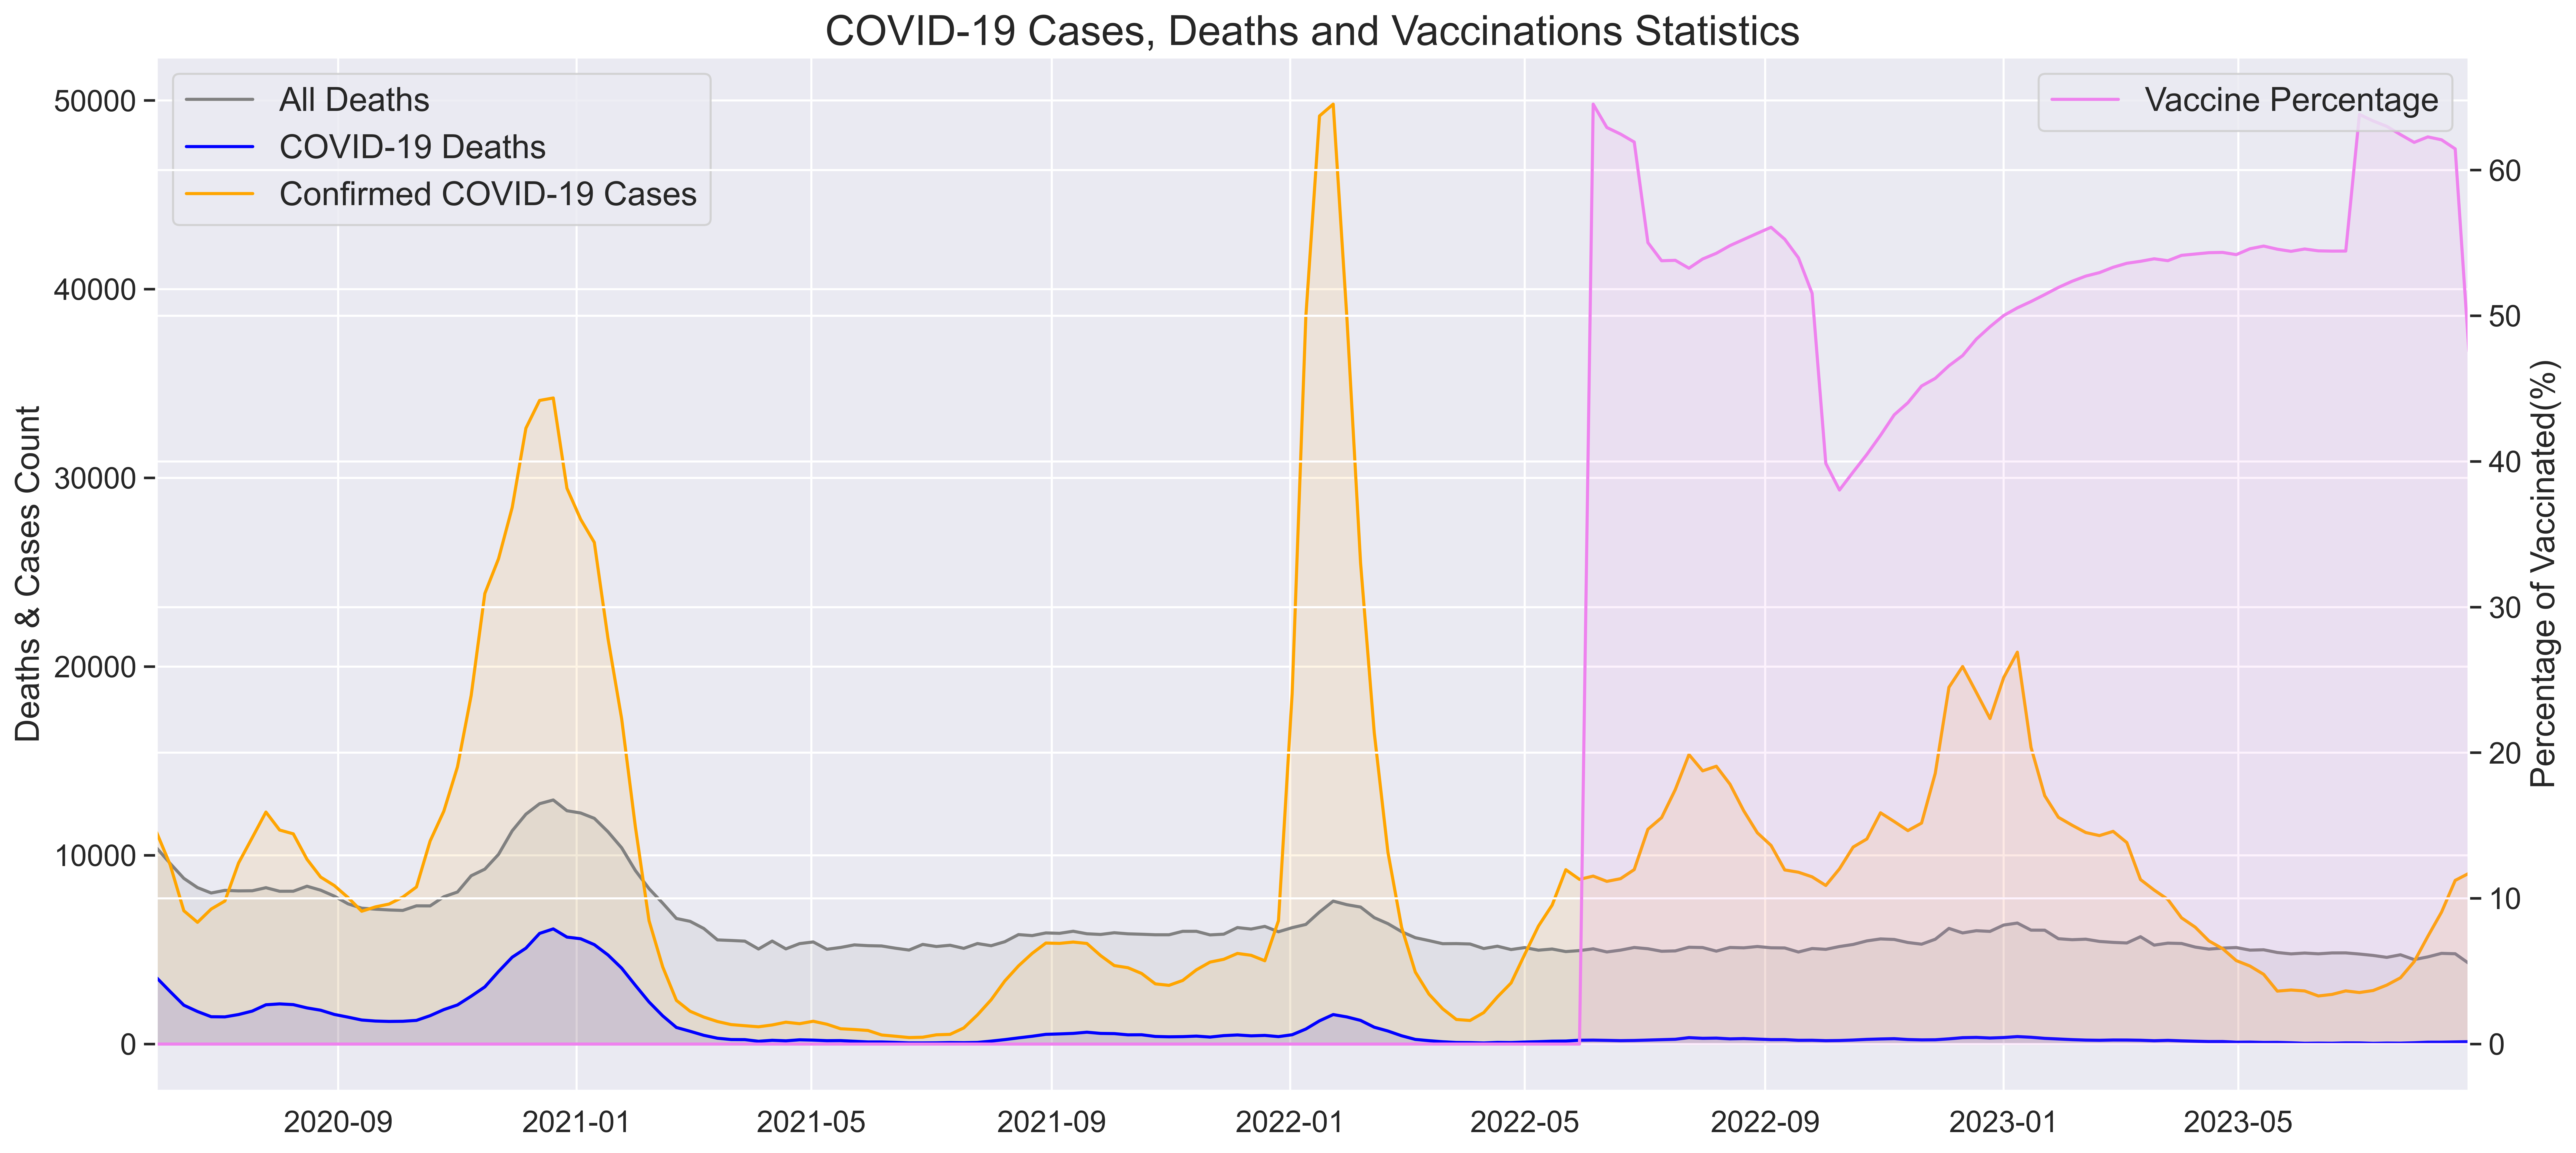

In [101]:
fig, ax = plt.subplots(1, 1, figsize=(20, 9))

plot_line(all_deaths, column='Residents Weekly All Deaths', color='grey', ax=ax, label='All Deaths')
plot_line(custom_sum_deaths, column='Residents Weekly COVID-19 Deaths', color='blue', ax=ax, label='COVID-19 Deaths')
plot_line(custom_sum_cases, column='Residents Weekly Confirmed COVID-19', color='orange', ax=ax, label='Confirmed COVID-19 Cases')
ax_twin = ax.twinx()
plot_line(up_to_date_vac, column='Percentage of Current Residents Up to Date with COVID-19 Vaccines', color='violet',  ax=ax_twin, label='Vaccine Percentage')

# Set up plots limits
start_end = [sane_df["Week Ending"].min(), sane_df["Week Ending"].max()]
ax.set_xlim(start_end)
ax_twin.set_xlim(start_end)

# Add labels and title with increased font sizes
ax.set_xlabel(None)
ax.set_ylabel("Deaths & Cases Count", fontsize=16)
ax_twin.set_ylabel("Percentage of Vaccinated(%)", fontsize=16)

# Add title 
plt.title("COVID-19 Cases, Deaths and Vaccinations Statistics", fontsize=20)

# Add legend
ax.legend(loc='upper left', fontsize=16)
ax_twin.legend(loc='upper right', fontsize=16)

# Increase the tick label font size
ax.tick_params(axis="both", labelsize="large")
ax_twin.tick_params(labelsize="large")

plt.show()

Let's perform a t-test to understand whether the number of deaths increased or decreased after they have started vaccinations, and if so - by how many standard errors and whether it's a statistically significant shift or not. 

We are going to use **Paired/Dependent 2-sample t-test:**, which is used to compare the mean of two samples drawn from the same population where each subject in the sample have been measured twice, before and after vaccination. First we are going to perform two-tails test to understand whether there is a difference in death cases at all. 

Is the difference in all death cases count before and after vaccination? (two tails) <br>
- $H_0: \mu_1 = \mu_2 \longrightarrow there \ is \ \underline{no} \ difference \ in \ the \ number \ of \ death\ cases\ before \ and \ after \ vaccination. $ (The null hypothesis is the default assumption that there is no statistically significant difference between the two groups.)
    
- $H_1: \mu_1 \ne \mu_2 \longrightarrow there \ is \ \underline{a} \ difference \ in \ the \ number \ of \ death\ cases\ before \ and \ after \ vaccination. $

 We are going to use 1% Significance Level (0.01)**:
   - A 1% significance level is one of the most conservative levels.
   - It's used when researchers want to be very cautious about making Type I errors and are willing to accept a higher risk of Type II errors (failing to detect true effects).
   - It's appropriate when the consequences of a Type I error are severe or when very strong evidence is required to reject the null hypothesis.

We run the test using Dependent t-test  formula:

$$ t = \frac{m}{s \ / \ \sqrt{n}}$$
<br>
1. calculate d: the differences between all pairs (deaths after minus before) <br>
m : mean of distribution <br>
s : standard deviation of distribution <br>
n : number of pairs <br>

In [26]:
slice_vac = sane_df[['Week Ending', 'Percentage of Current Residents Up to Date with COVID-19 Vaccines', 'Residents Weekly All Deaths']]
slice_vac

Week Ending  \
1        2020-05-31   
2        2020-06-07   
3        2020-06-14   
4        2020-06-21   
5        2020-06-28   
...             ...   
2596194  2023-07-30   
2596195  2023-08-06   
2596196  2023-08-13   
2596197  2023-08-20   
2596198  2023-08-27   

         Percentage of Current Residents Up to Date with COVID-19 Vaccines  \
1                                                      NaN                   
2                                                      NaN                   
3                                                      NaN                   
4                                                      NaN                   
5                                                      NaN                   
...                                                    ...                   
2596194                                             47.297                   
2596195                                             46.053                   
2596196                                             49.315                   
2596197                                              0.000                   
2596198                                              0.000                   

         Residents Weekly All Deaths  
1                                0.0  
2                                0.0  
3                                0.0  
4                                0.0  
5                                1.0  
...                              ...  
2596194                          0.0  
2596195                          0.0  
2596196                          1.0  
2596197                          0.0  
2596198                          0.0  

[2552111 rows x 3 columns]

In [27]:
print(slice_vac['Residents Weekly All Deaths'].isna().sum())
slice_vac['Week Ending'].isna().sum()

59


0

In [28]:
slice_vac.loc[:, 'Week Ending'] = slice_vac['Week Ending'].dropna()

In [29]:
slice_vac_notna = slice_vac[pd.notna(slice_vac['Percentage of Current Residents Up to Date with COVID-19 Vaccines'])].copy()
slice_vac_notna

Week Ending  \
53       2021-05-30   
54       2021-06-06   
55       2021-06-13   
56       2021-06-20   
57       2021-06-27   
...             ...   
2596194  2023-07-30   
2596195  2023-08-06   
2596196  2023-08-13   
2596197  2023-08-20   
2596198  2023-08-27   

         Percentage of Current Residents Up to Date with COVID-19 Vaccines  \
53                                                   0.000                   
54                                                   0.000                   
55                                                   0.000                   
56                                                   0.000                   
57                                                   0.000                   
...                                                    ...                   
2596194                                             47.297                   
2596195                                             46.053                   
2596196                                             49.315                   
2596197                                              0.000                   
2596198                                              0.000                   

         Residents Weekly All Deaths  
53                               1.0  
54                               0.0  
55                               1.0  
56                               0.0  
57                               0.0  
...                              ...  
2596194                          0.0  
2596195                          0.0  
2596196                          1.0  
2596197                          0.0  
2596198                          0.0  

[1741541 rows x 3 columns]

In [30]:
slice_vac_na = slice_vac[pd.isna(slice_vac['Percentage of Current Residents Up to Date with COVID-19 Vaccines'])]
slice_vac_na

Week Ending  \
1        2020-05-31   
2        2020-06-07   
3        2020-06-14   
4        2020-06-21   
5        2020-06-28   
...             ...   
2595134  2021-05-09   
2595135  2021-05-16   
2595136  2021-05-23   
2595390  2023-08-27   
2595502  2023-08-27   

         Percentage of Current Residents Up to Date with COVID-19 Vaccines  \
1                                                      NaN                   
2                                                      NaN                   
3                                                      NaN                   
4                                                      NaN                   
5                                                      NaN                   
...                                                    ...                   
2595134                                                NaN                   
2595135                                                NaN                   
2595136                                                NaN                   
2595390                                                NaN                   
2595502                                                NaN                   

         Residents Weekly All Deaths  
1                                0.0  
2                                0.0  
3                                0.0  
4                                0.0  
5                                1.0  
...                              ...  
2595134                          0.0  
2595135                          0.0  
2595136                          0.0  
2595390                          0.0  
2595502                          0.0  

[810570 rows x 3 columns]

In [31]:
len(slice_vac_notna), len(slice_vac_na)

(1741541, 810570)

In [32]:
# Number of all deaths groupped by week across the whole country before vaccination
deaths_bef = slice_vac_na[slice_vac_na['Week Ending'] < '2021-05-30'].groupby('Week Ending').sum().drop(columns=['Percentage of Current Residents Up to Date with COVID-19 Vaccines']).reset_index()
deaths_bef

Week Ending  Residents Weekly All Deaths
0   2020-05-31                      10403.0
1   2020-06-07                       9571.0
2   2020-06-14                       8781.0
3   2020-06-21                       8290.0
4   2020-06-28                       8005.0
5   2020-07-05                       8144.0
6   2020-07-12                       8116.0
7   2020-07-19                       8123.0
8   2020-07-26                       8285.0
9   2020-08-02                       8097.0
10  2020-08-09                       8099.0
11  2020-08-16                       8364.0
12  2020-08-23                       8154.0
13  2020-08-30                       7838.0
14  2020-09-06                       7430.0
15  2020-09-13                       7201.0
16  2020-09-20                       7147.0
17  2020-09-27                       7106.0
18  2020-10-04                       7081.0
19  2020-10-11                       7324.0
20  2020-10-18                       7321.0
21  2020-10-25                       7805.0
22  2020-11-01                       8057.0
23  2020-11-08                       8918.0
24  2020-11-15                       9268.0
25  2020-11-22                      10052.0
26  2020-11-29                      11301.0
27  2020-12-06                      12181.0
28  2020-12-13                      12737.0
29  2020-12-20                      12934.0
30  2020-12-27                      12364.0
31  2021-01-03                      12245.0
32  2021-01-10                      11961.0
33  2021-01-17                      11249.0
34  2021-01-24                      10399.0
35  2021-01-31                       9196.0
36  2021-02-07                       8235.0
37  2021-02-14                       7464.0
38  2021-02-21                       6655.0
39  2021-02-28                       6503.0
40  2021-03-07                       6124.0
41  2021-03-14                       5519.0
42  2021-03-21                       5489.0
43  2021-03-28                       5454.0
44  2021-04-04                       5036.0
45  2021-04-11                       5458.0
46  2021-04-18                       5043.0
47  2021-04-25                       5322.0
48  2021-05-02                       5411.0
49  2021-05-09                       5023.0
50  2021-05-16                       5119.0
51  2021-05-23                       5255.0

In [33]:
# Number of all deaths groupped by week across the whole country after vaccination
deaths_aft = slice_vac_notna.groupby('Week Ending').sum().drop(columns=['Percentage of Current Residents Up to Date with COVID-19 Vaccines']).reset_index()[:52]
deaths_aft

Week Ending  Residents Weekly All Deaths
0   2021-05-30                       2719.0
1   2021-06-06                       4050.0
2   2021-06-13                       4912.0
3   2021-06-20                       4920.0
4   2021-06-27                       5217.0
5   2021-07-04                       5097.0
6   2021-07-11                       5193.0
7   2021-07-18                       5050.0
8   2021-07-25                       5304.0
9   2021-08-01                       5196.0
10  2021-08-08                       5393.0
11  2021-08-15                       5773.0
12  2021-08-22                       5731.0
13  2021-08-29                       5834.0
14  2021-09-05                       5847.0
15  2021-09-12                       5956.0
16  2021-09-19                       5794.0
17  2021-09-26                       5776.0
18  2021-10-03                       5876.0
19  2021-10-10                       5818.0
20  2021-10-17                       5801.0
21  2021-10-24                       5767.0
22  2021-10-31                       5743.0
23  2021-11-07                       5949.0
24  2021-11-14                       5944.0
25  2021-11-21                       5758.0
26  2021-11-28                       5795.0
27  2021-12-05                       6157.0
28  2021-12-12                       6088.0
29  2021-12-19                       6218.0
30  2021-12-26                       5928.0
31  2022-01-02                       6151.0
32  2022-01-09                       6333.0
33  2022-01-16                       6974.0
34  2022-01-23                       7564.0
35  2022-01-30                       7346.0
36  2022-02-06                       7254.0
37  2022-02-13                       6682.0
38  2022-02-20                       6364.0
39  2022-02-27                       5938.0
40  2022-03-06                       5624.0
41  2022-03-13                       5469.0
42  2022-03-20                       5312.0
43  2022-03-27                       5316.0
44  2022-04-03                       5290.0
45  2022-04-10                       5049.0
46  2022-04-17                       5182.0
47  2022-04-24                       5000.0
48  2022-05-01                       5101.0
49  2022-05-08                       4971.0
50  2022-05-15                       5031.0
51  2022-05-22                       4892.0

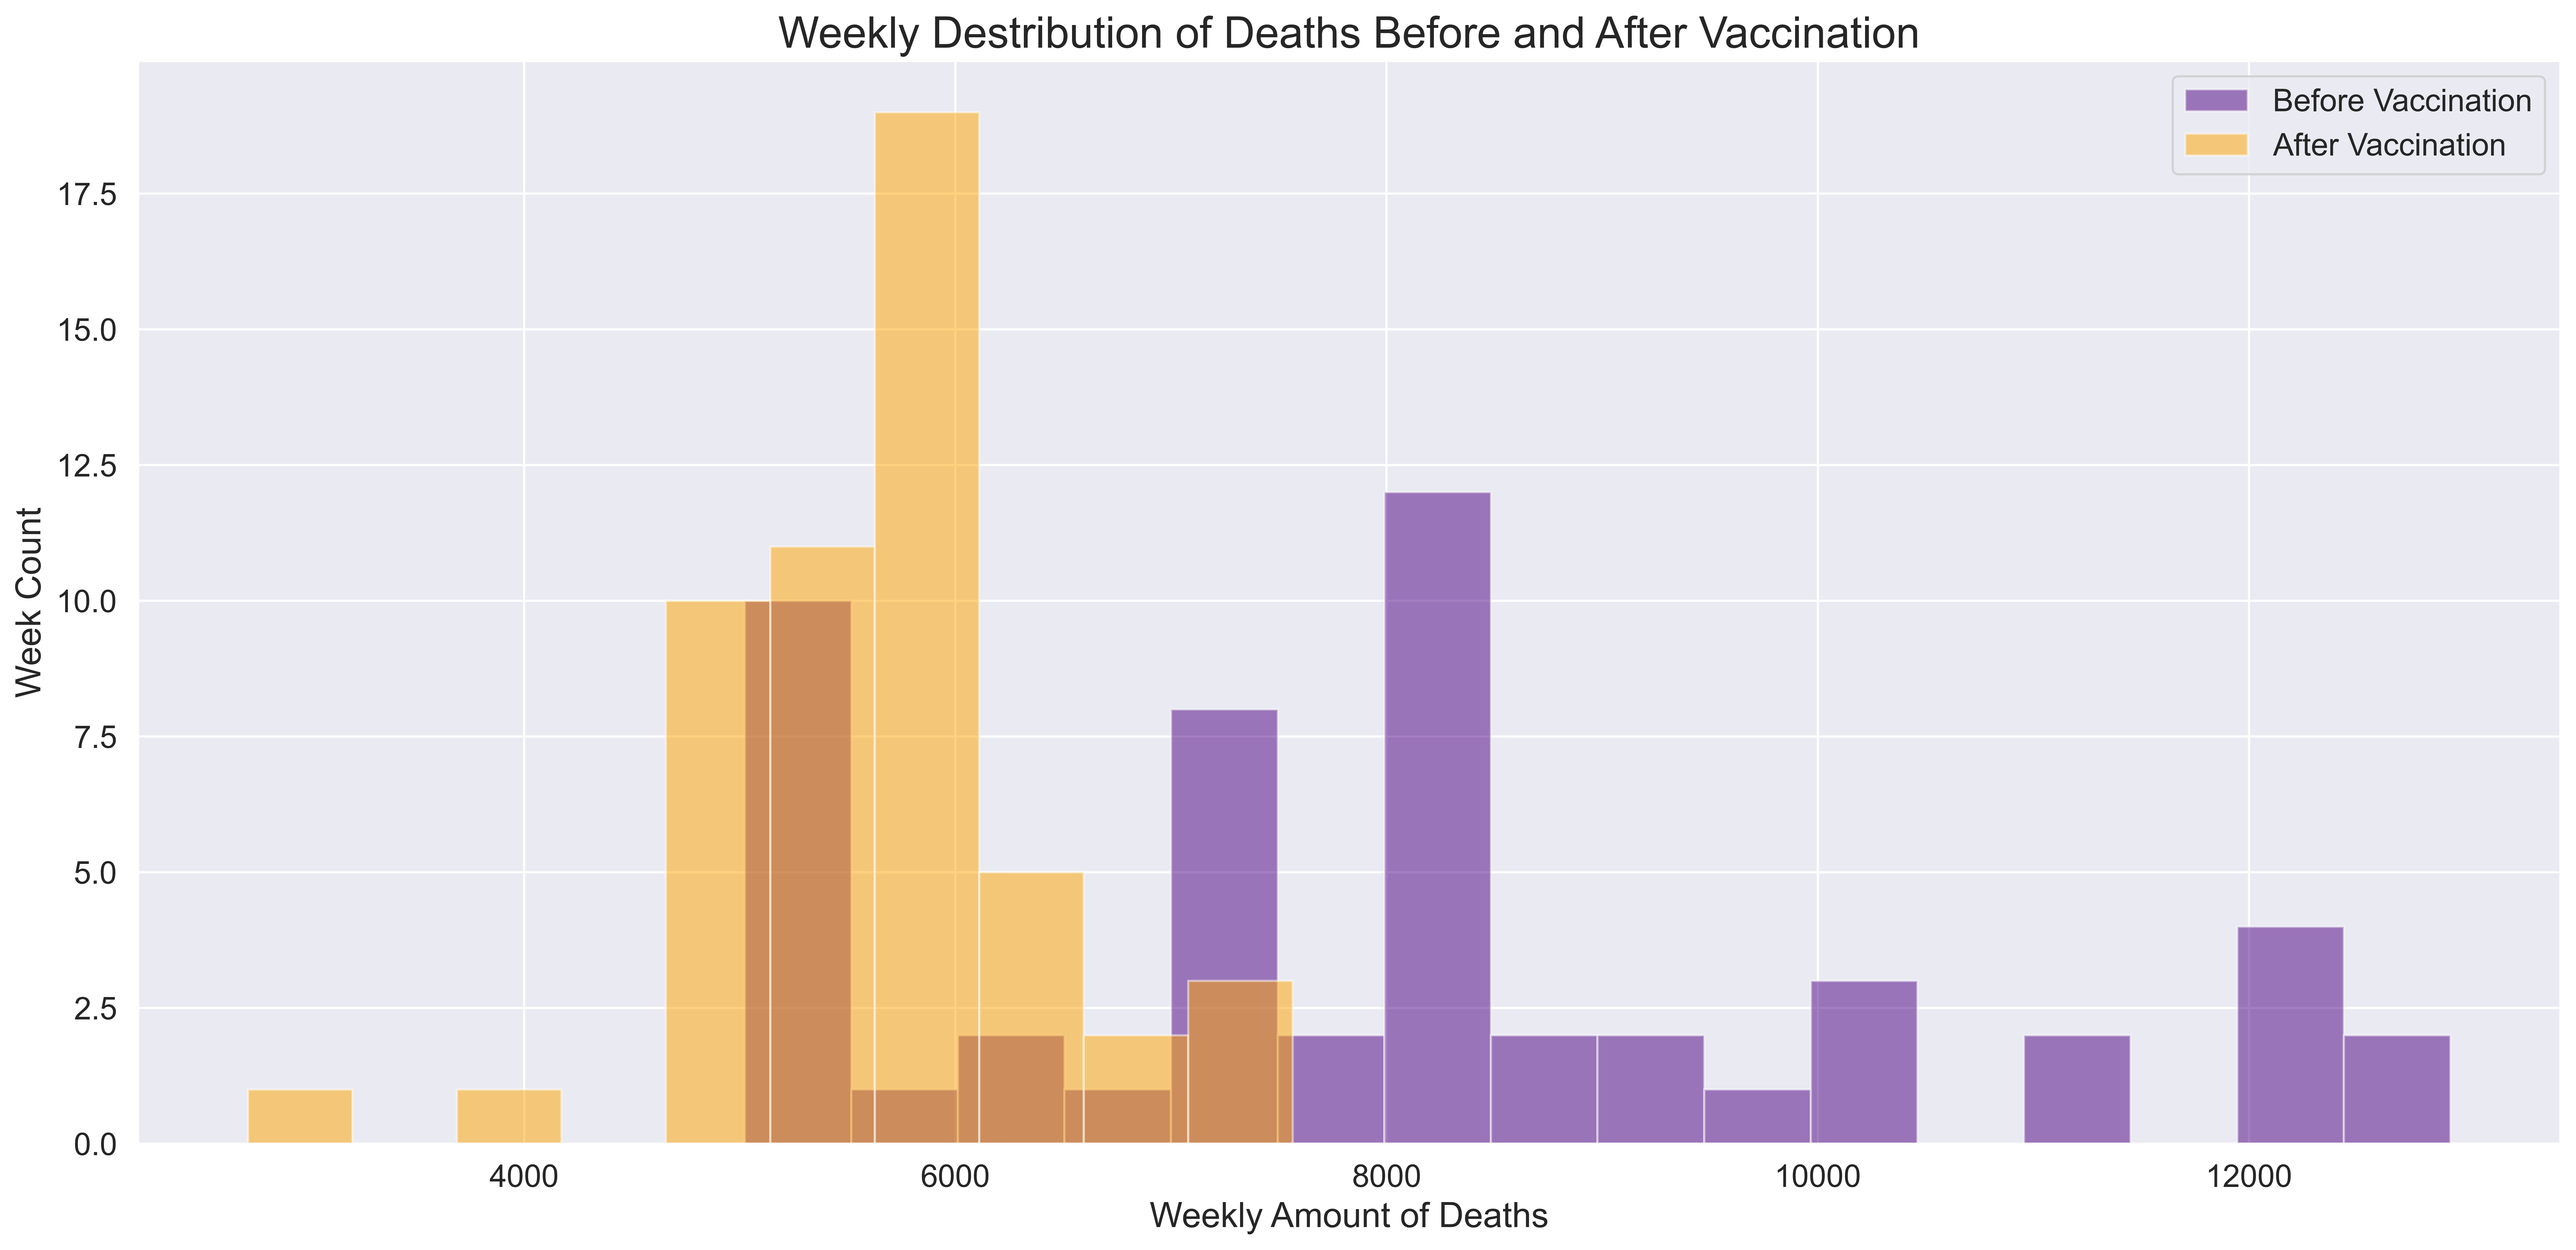

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(20, 9))

plt.hist(deaths_bef['Residents Weekly All Deaths'], alpha=0.5, label='Before Vaccination',  bins=16, color='indigo')
plt.hist(deaths_aft['Residents Weekly All Deaths'], alpha=0.5, label='After Vaccination', bins=10, color='orange')

# Add labels and title with increased font sizes
ax.set_xlabel('Weekly Amount of Deaths', fontsize=16)
ax.set_ylabel("Week Count", fontsize=16)

# Add title with x-large font size
plt.title("Weekly Destribution of Deaths Before and After Vaccination", fontsize=20)

# Add legend
ax.legend(loc='upper right', fontsize="large")

# Increase the tick label font size
ax.tick_params(axis="both", labelsize="large")

plt.show()

The t-test calculates a test statistic (tstat) and a p-value. The test statistic represents how many standard errors the sample mean is away from the null hypothesis's expected mean. The p-value tells us the probability of observing such a difference by random chance.


In [69]:
from scipy.stats import ttest_ind
tstat, pval = ttest_ind(deaths_bef['Residents Weekly All Deaths'], deaths_aft['Residents Weekly All Deaths'])
tstat, pval

(7.568048031257491, 1.740000346862707e-11)

We alculate the t-statistic and p-value for a two-sample independent t-test. This test is used to determine if there is a statistically significant difference between the means of two independent groups or samples. In your case, it's comparing the means of the "Residents Weekly All Deaths" in the `deaths_bef` group (before vaccination) and the `deaths_aft` group (after vaccination). The t-statistic measures the size of the difference relative to the variation in your data, and the p-value tells you the significance of that difference. If the p-value is below a chosen significance level (often 0.05 or 0.01), it suggests that the means of the two groups are significantly different.

Sample mean differs from population mean by ~7.5 standard errors. 

The p-value we obtained from the t-test is used to determine the significance of the results. If the p-value is less than a chosen significance level , we reject the null hypothesis in favor of the alternative hypothesis. The chosen significance level represents the probability of making a Type I error (i.e., incorrectly rejecting the null hypothesis when it is actually true).

In [70]:
a = 0.01
pval < a

True

We can already reject the null hypothesis, but let's calculate the threshold value to check the `tstat`.

In [71]:
dof = len(deaths_aft) - 1
dof

51

`If there are no threshold for 51 degrees of freedom scale dof down, not up!!!`

In [72]:
thresh = 2.704  # from the table with dof = 51 and alpha = 1% 

Above we mentioned using a significance level of 1%. When we compare the absolute value of the t-statistic (`tstat`) to the threshold (`thresh`).

In [73]:
(tstat < -thresh) | (thresh < tstat) 

True

In our output, we have `(tstat < -thresh) | (thresh < tstat) = True`, which means that **the absolute value of tstat exceeds the threshold**, and we can **reject the null hypothesis**. Therefore, we conclude that there is a significant difference in the number of death cases before and after vaccination, based on the chosen significance level of 1%.

In simpler terms, we have enough statistical evidence to support the claim that vaccination had an impact on the number of death cases.


When you are comparing death rates and find that the sample mean is significantly different from the expected mean by 7.568048031257491 standard errors, it means that the observed death rate in your sample is significantly lower (or higher, depending on the sign of the t-statistic) than what you would expect based on the null hypothesis.

Specifically, here's what it means:

1. **Sample Death Rate**: The sample death rate is the calculated rate of deaths in your sample population. It represents the observed mortality in your sample.

2. **Null Hypothesis's Expected Death Rate**: The null hypothesis often assumes a specific expected death rate, typically based on historical data or a predetermined reference rate.

3. **Standard Error**: The standard error measures the variability or uncertainty in your sample death rate due to random sampling. It quantifies how much you would expect the death rate to vary if you were to take multiple random samples from the same population.

When the t-statistic is 7.568048031257491, it indicates that your observed sample death rate is significantly lower than the expected death rate under the null hypothesis. The magnitude of the t-statistic (7.568) suggests that this difference is quite substantial and unlikely to have occurred by random chance alone.

In the context of comparing death rates, this result suggests that there is strong evidence that the actual death rate in your sample population is significantly different from what would be expected if there were no real difference (according to the null hypothesis). The small p-value associated with this t-statistic indicates that the difference is statistically significant, and you would typically reject the null hypothesis in favor of the alternative hypothesis, which suggests a significant difference in death rates.

In practical terms, it means that something, such as a vaccination program or another intervention, may have had a substantial impact on reducing mortality compared to what would have been expected based on historical data or other reference rates.

In [74]:
def translate_geometries(df, x, y, scale, rotate):
    df.loc[:, "geometry"] = df.geometry.translate(yoff=y, xoff=x)
    center = df.dissolve().centroid.iloc[0]
    df.loc[:, "geometry"] = df.geometry.scale(xfact=scale, yfact=scale, origin=center)
    df.loc[:, "geometry"] = df.geometry.rotate(rotate, origin=center)
    return df


def adjust_maps(df):
    df_main_land = df[~df.STATEFP.isin(["02", "15"])]
    df_alaska = df[df.STATEFP == "02"]
    df_hawaii = df[df.STATEFP == "15"]

    df_alaska = translate_geometries(df_alaska, 1300000, -4900000, 0.5, 32)
    df_hawaii = translate_geometries(df_hawaii, 5400000, -1500000, 1, 24)

    return pd.concat([df_main_land, df_alaska, df_hawaii])


states = gpd.read_file("./data/cb_2018_us_state_500k.zip")
states = states[~states.STATEFP.isin(["72", "69", "60", "66", "78"])]
states = adjust_maps(states.to_crs("ESRI:102003"))

In [75]:
# Determine the luminance threshold (you can adjust this value)
luminance_threshold = 0.5

# Create a function to determine text color based on luminance
def get_text_color(hex_color):
    rgb_color = mcolors.hex2color(hex_color)
    luminance = 0.2126 * rgb_color[0] + 0.7152 * rgb_color[1] + 0.0722 * rgb_color[2]
    return 'white' if luminance < luminance_threshold else 'black'

C:\Users\Julia\AppData\Local\Temp\ipykernel_21480\71028461.py:21: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(


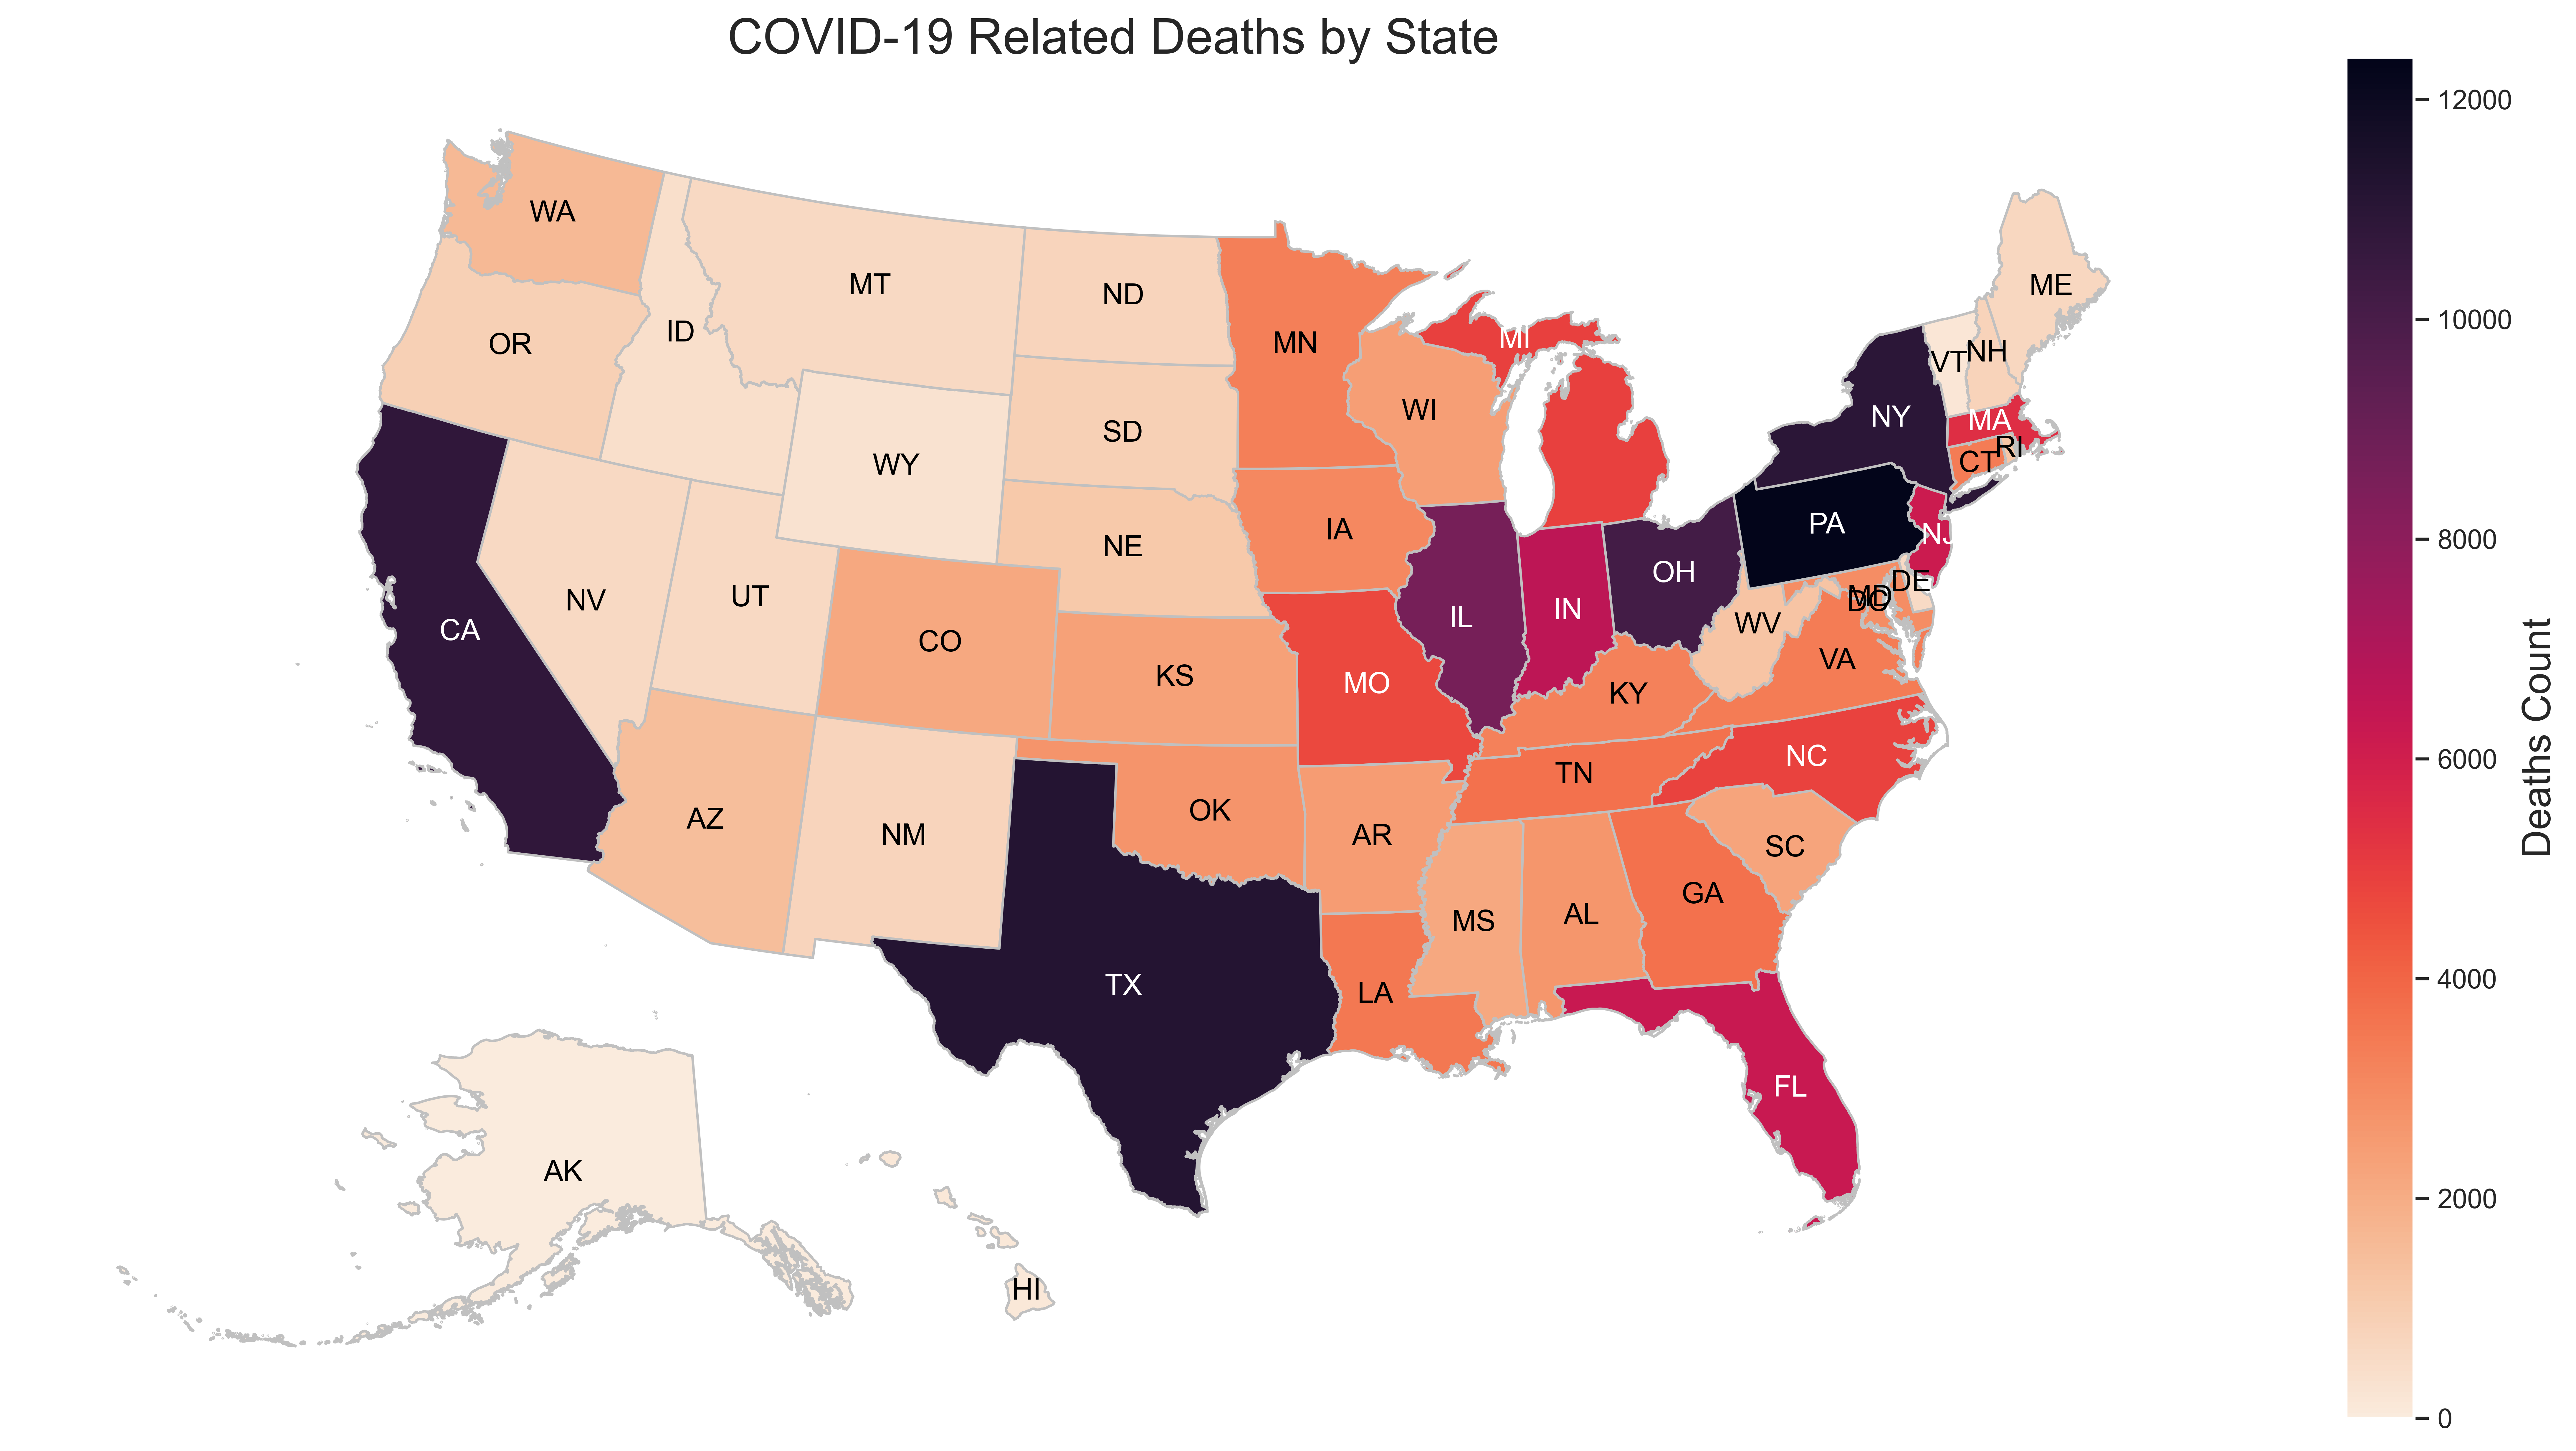

In [81]:
colormap = sns.color_palette("rocket_r", as_cmap=True)

deaths_by_state = (
    df.groupby("Provider State")["Residents Weekly COVID-19 Deaths"].sum().reset_index()
)
min_deaths = deaths_by_state["Residents Weekly COVID-19 Deaths"].min()
max_deaths = deaths_by_state["Residents Weekly COVID-19 Deaths"].max()
deaths_by_state["All Deaths Color"] = deaths_by_state[
    "Residents Weekly COVID-19 Deaths"
].apply(lambda x: colormap(x / max_deaths))

geo_death_states = states.merge(
    right=deaths_by_state, how="left", left_on="STUSPS", right_on="Provider State"
)
geoax = geo_death_states.plot(
    edgecolor="Silver", color=geo_death_states["All Deaths Color"], figsize=(20, 10)
)


plt.axis("off")
cbar = plt.colorbar(
    mpl.cm.ScalarMappable(
        norm=mpl.colors.Normalize(vmin=min_deaths, vmax=max_deaths), cmap=colormap
    )
)

# Set title for the color bar
cbar.set_label("Deaths Count", fontsize=16)

for x, y, label, state_color in zip(
    geo_death_states.geometry.representative_point().x,
    geo_death_states.geometry.representative_point().y,
    geo_death_states["STUSPS"],
    geo_death_states["All Deaths Color"],
):
    text_color = get_text_color(state_color)
    geoax.text(x, y, label, fontsize=12, ha="center", va="center", color=text_color)

# Set plot title
plt.title("COVID-19 Related Deaths by State", fontsize=20)

plt.show()


C:\Users\Julia\AppData\Local\Temp\ipykernel_21480\2027406040.py:27: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(


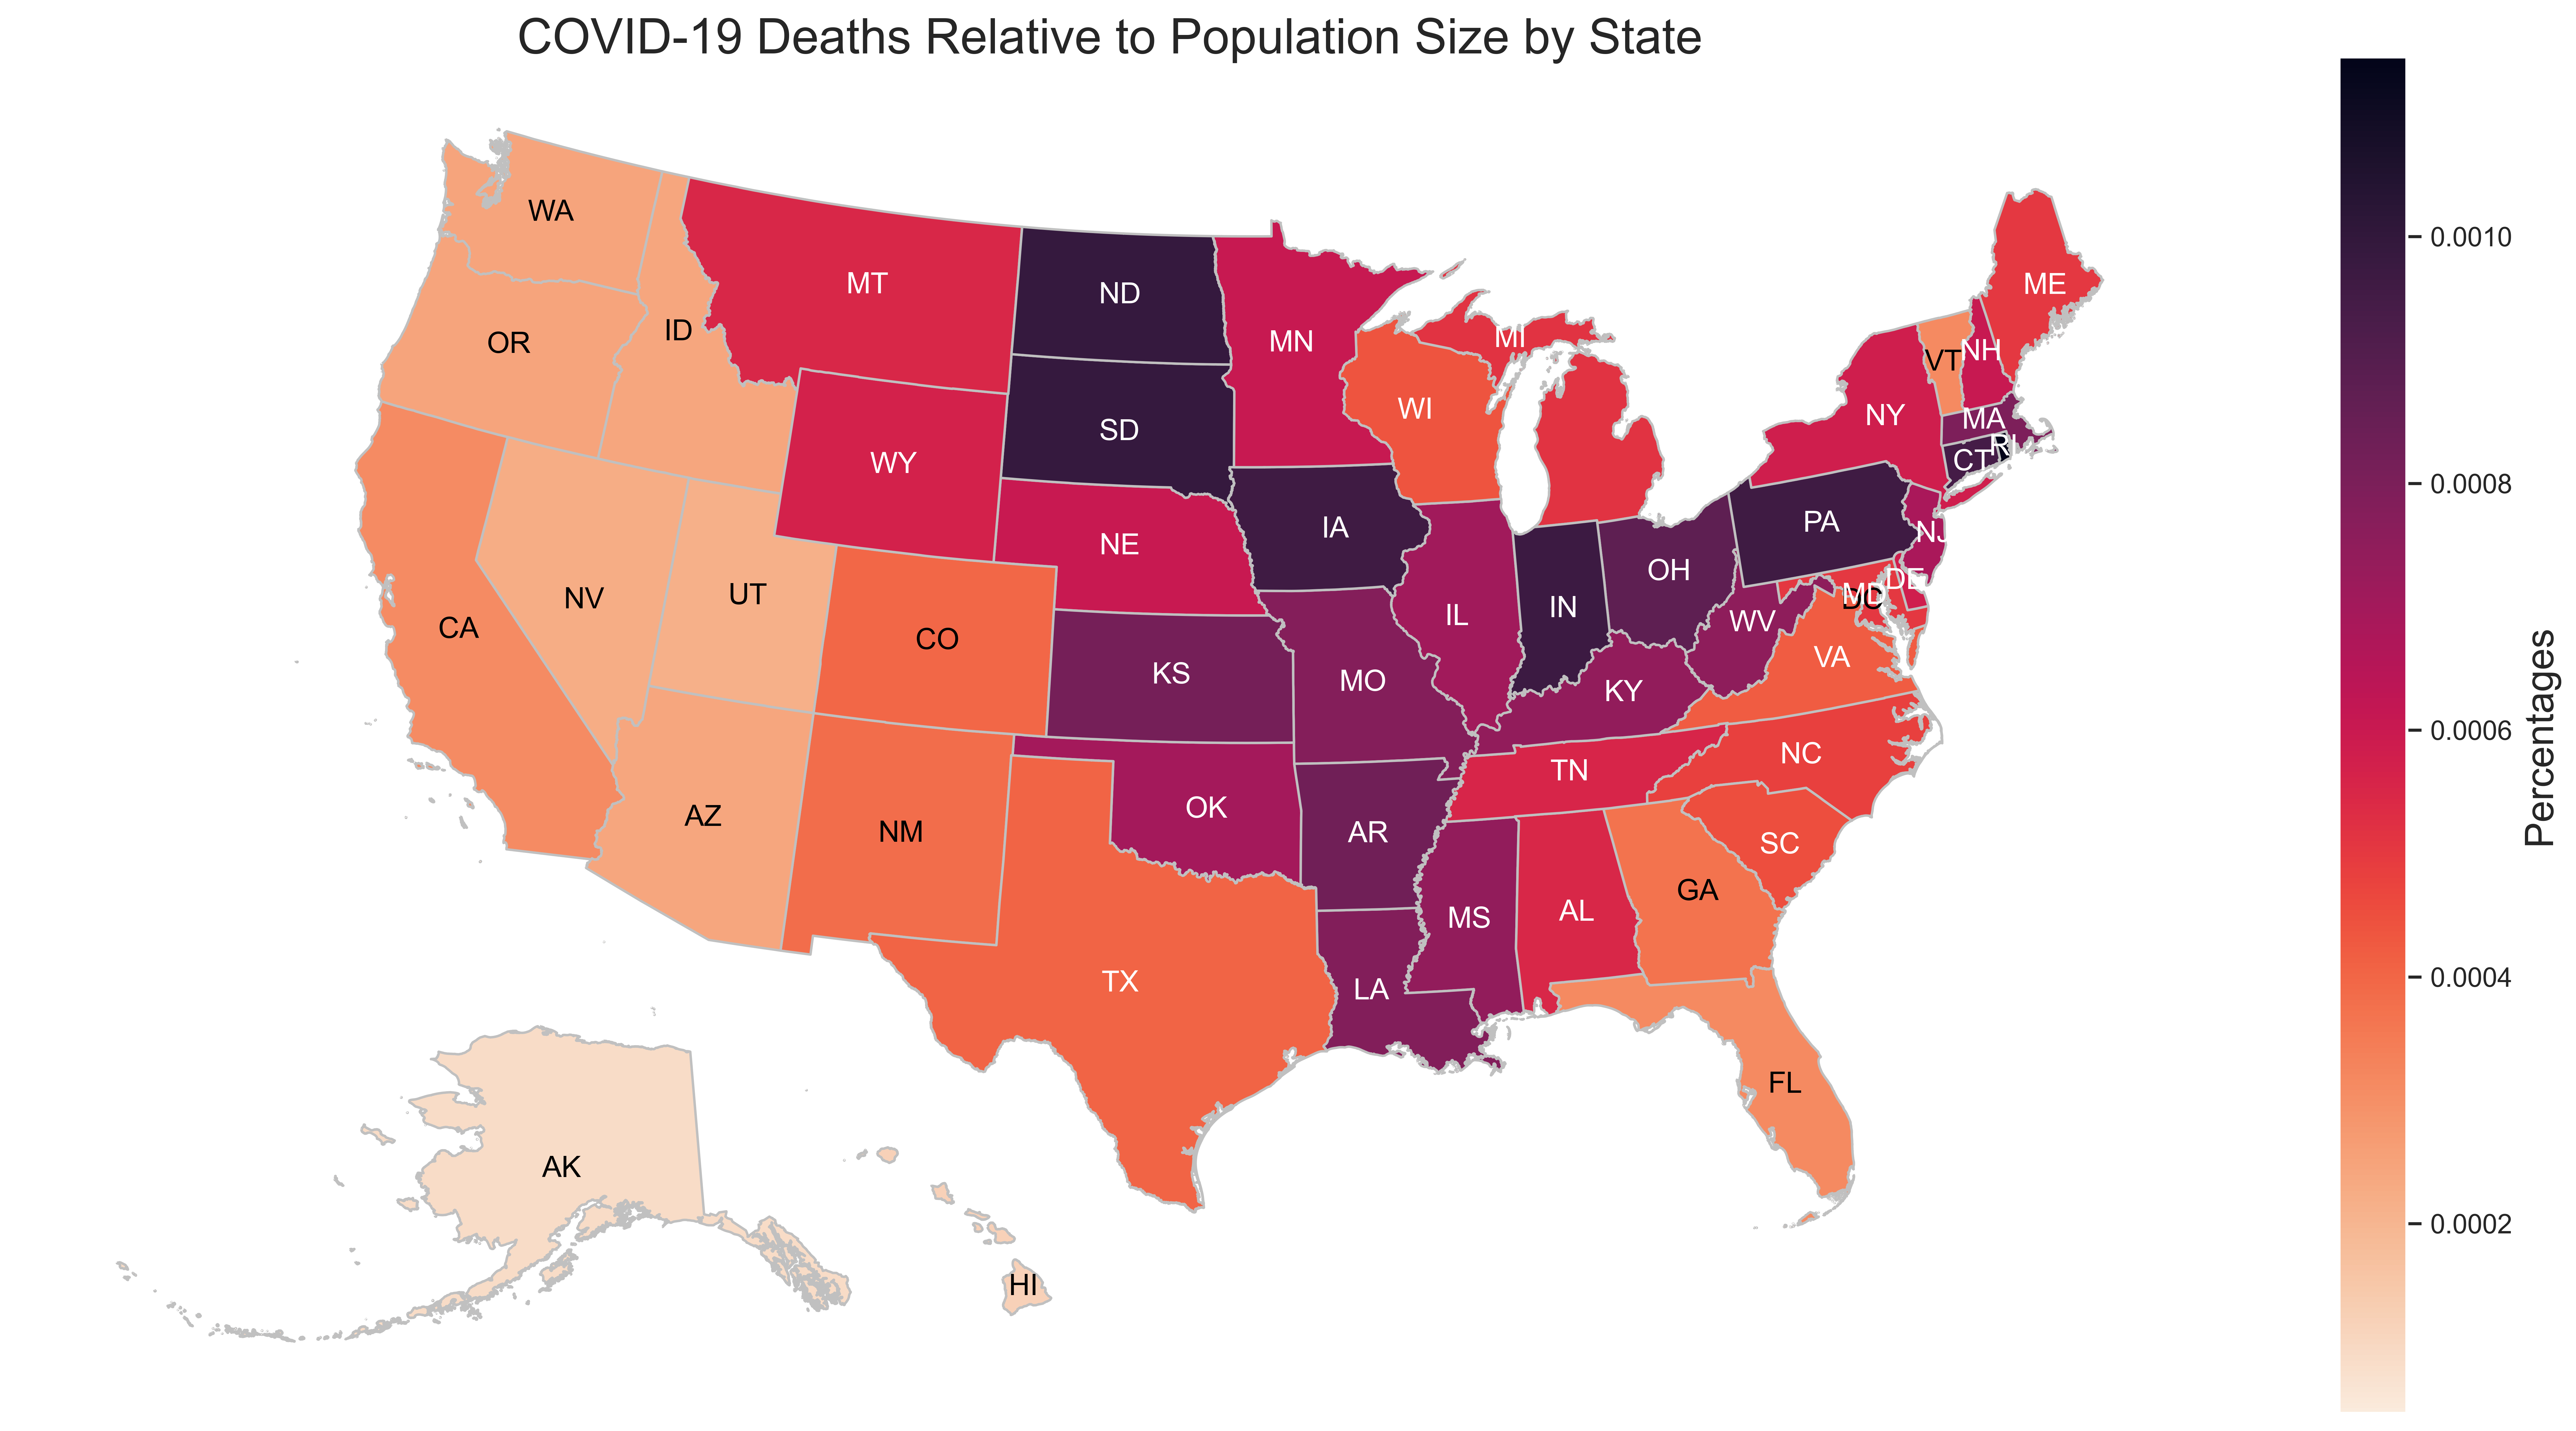

In [82]:
colormap = sns.color_palette("rocket_r", as_cmap=True)

deaths_by_state = (
    df.groupby("Provider State")["Residents Weekly COVID-19 Deaths"].sum().reset_index()
)

geo_death_states = states.merge(
    right=deaths_by_state, how="left", left_on="STUSPS", right_on="Provider State"
).merge(
    right=states_pop, how="left", left_on="NAME", right_on="State"
)
geo_death_states["Deaths by Population"] = geo_death_states[
    "Residents Weekly COVID-19 Deaths"
] / geo_death_states["2022-07-01"]
min_deaths = geo_death_states["Deaths by Population"].min()
max_deaths = geo_death_states["Deaths by Population"].max()
geo_death_states["Deaths by Population Color"] = (geo_death_states[
    "Deaths by Population"
]).apply(lambda x: colormap(x / max_deaths))

geoax = geo_death_states.plot(
    edgecolor="Silver", color=geo_death_states["Deaths by Population Color"], figsize=(20, 10)
)


plt.axis("off")
cbar = plt.colorbar(
    mpl.cm.ScalarMappable(
        norm=mpl.colors.Normalize(vmin=min_deaths, vmax=max_deaths), cmap=colormap
    )
)

# Set title for the color bar
cbar.set_label("Percentages", fontsize=16)

for x, y, label, state_color in zip(
    geo_death_states.geometry.representative_point().x,
    geo_death_states.geometry.representative_point().y,
    geo_death_states["STUSPS"],
    geo_death_states["Deaths by Population Color"],
):
    text_color = get_text_color(state_color)
    geoax.text(x, y, label, fontsize=12, ha="center", va="center", color=text_color)

# Set plot title
plt.title("COVID-19 Deaths Relative to Population Size by State", fontsize=20)

plt.show()
